# Rapport : Estimation de modèles spatio-temporels par deep learning 

## MIA Paris Saclay - Centre de Géosciences Mines Paris - Vincent Fourmigué


## Mise en contexte : Géostatistique
On a des données spatialisées, ayant des
coordonnées (x,y) en plus de leurs valeurs.
On les modélise par champs aléatoire Gaussien de
Matérn de paramètres θ = (ν,ρ,σ) 
Pour estimer les paramètres θ, on maximise la vraisemblance --> inverser matrice de covariance --> O(ncube) operations --> devient impossible pour grand n

## Inférence amortie
On sait simuler de manière peu couteuse des réalisations de champs de Matérn selon des paramètres choisis --> constitue le jeu d’entrainement.
<br>
On estime θ par apprentissage supervisé.  
<br>
Une fois le NN entraîné l'estimation de θ est instantanée on parle alors d'inférence amortie.



### Quelle architecture pour le NN?
Si les données sont sur grille, CNN (Sainsbury-Dale et al., 2023)
<br>
Si les données sont éparses, GNN (Sainsbury-Dale et al., 2024)
<br>
Si données spatio-temporelles ? ...

## Le type de données 

Les données d’entrainements sont des échantillons de champs Gaussien de Matérn choisisselon un processus ponctuel sur le domaine spatial (double processus de Poisson).
<br>
Cet échantillon de points est étiqueté avec les paramètres θ ayant permis la simulation.
<br>
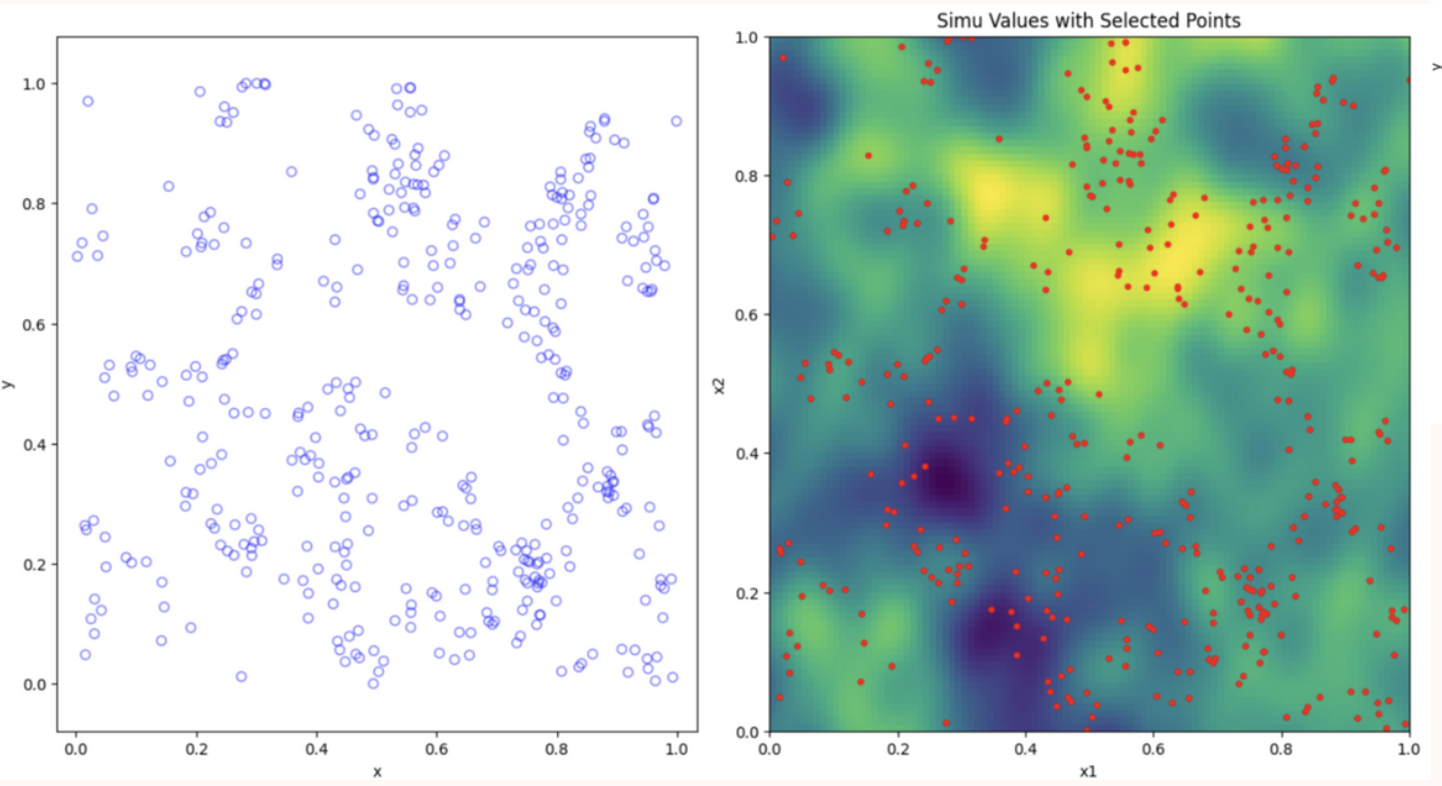
<br>




# Données spatiales vue comme un graphe dans le cas d'un GNN
Réalisation d’un graphe à partir de ces points qui deviennent alors les noeuds du graphe.
<br>
Ne sont reliés que les points qui sont à une distance infèrieure à un seuil.
<br>
Le poids des arrêtes dépend la distance entre les points.
<br>
<br>
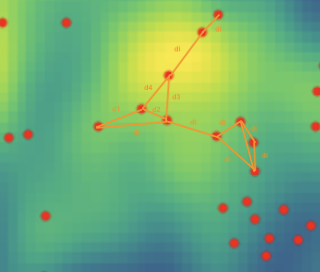

## Description générale du modèle issu du papier : Neural Bayes Estimators for Irregular Spatial Data using Graph Neural Networks
authors : Matthew Sainsbury-Dale, Andrew Zammit-Mangion, Jordan Richards, Raphaël Huser
<br>
Le modèle est un modèle de convolution sur graphes qui est constitué de plusieurs modules consécutifs :
<br>
- Le module de propagation qui effectue les convolutions sur graphs.
<br>
- Le module readout qui effectue un pooling sur les poids des noeuds d'un graph et ressort un vecteur R nommé summary statistic, de taille 20.
<br>
- Le module de mapping qui est constitué d'un MLP simple qui fait le lien entre le vecteur de taille 20 sorti du module readout et un vecteur θ qui a pour taille le nombre de paramètres que l'on cherche à estimer dans le champ de Matèrn. 
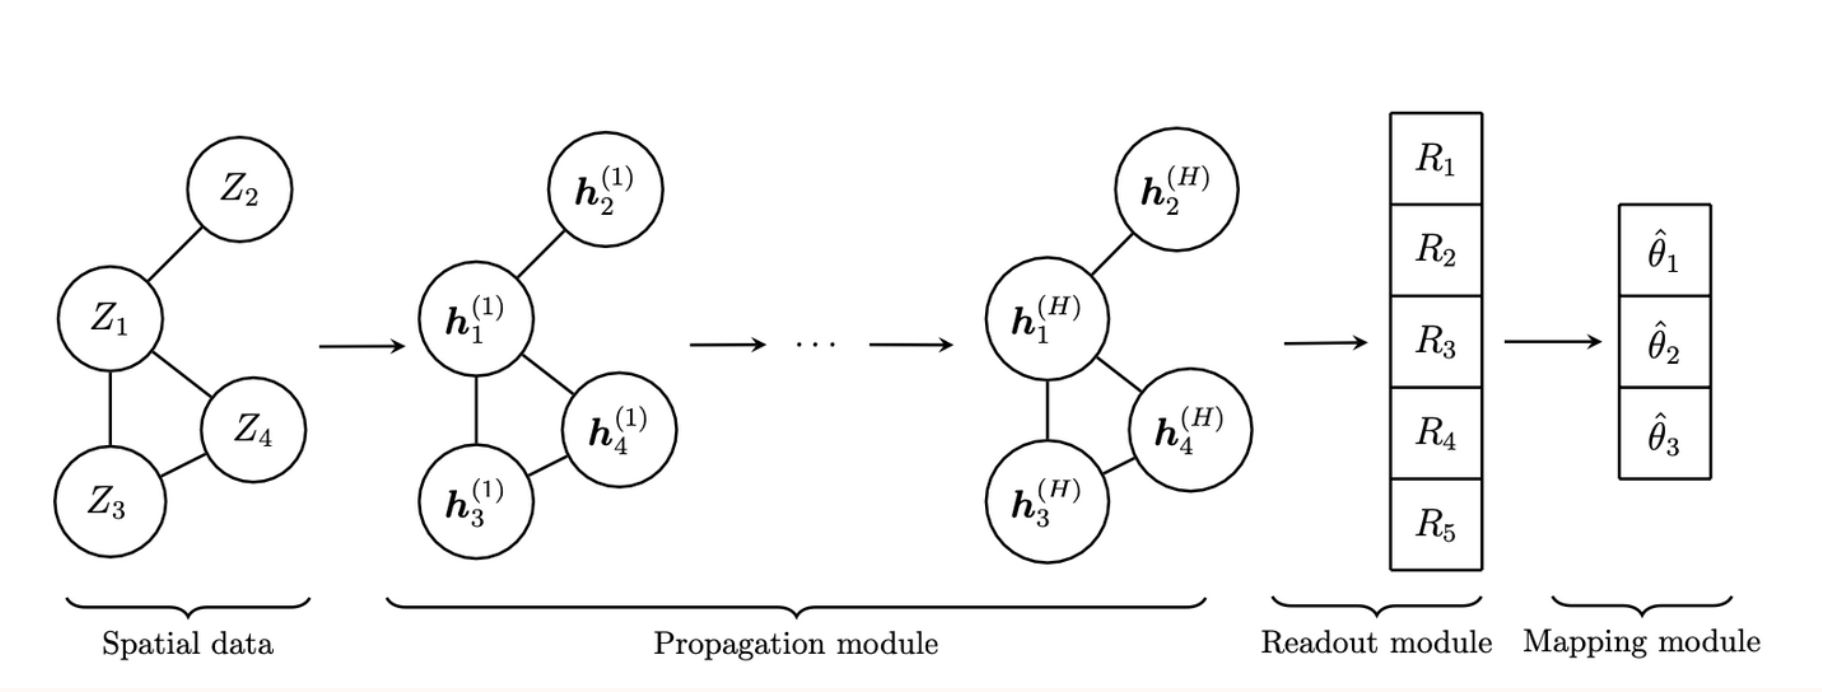
<br>


## Description détaillée du module de Propagation - Message Passing et coeur de GNN


## Particularité de la vision globale des données utilisation d'un DEEPSET
<br>
Zaheer, M., Kottur, S., Ravanbakhsh, S., Poczos, B., Salakhutdinov, R. R., and Smola, A. J. (2017). Deep sets. In Proceedings of the 31st Conference on Neural Information Processing Systems,
<br>
<br>
L'idée de l'architecture DeepSets lors de l'entraînement est de rajouter plusieurs réalisation de champs de Matèrn différents mais ayant en commun les paramètres que l'on cherche à estimer.
<br>
On réalise ensuite un pooling sur les R (vecteurs de summary statistic) issus des m graphes qui partagents les mêmes paramètres.
<br>
L'architecture DeepSet n'impacte que le début de notre structure.

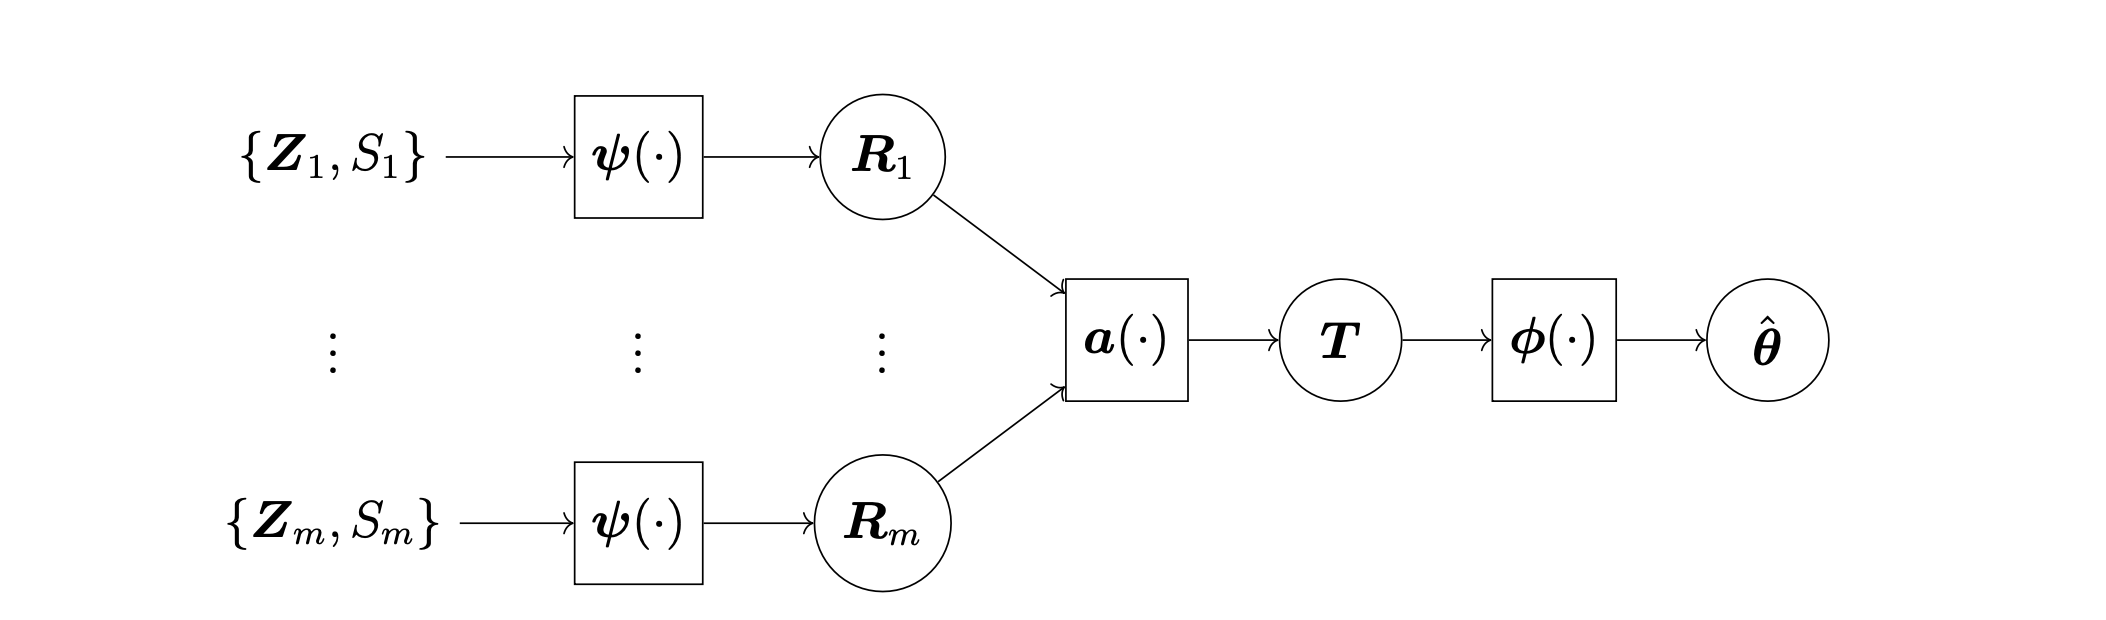

<br>
Cependant cette architecture est responsable de la vision que l'on a des données :
<br>
on considère desormais une donnée comme un graphe composé de m composantes non connexes et étiquetés par les paramètres y=θ que l'on cherche à estimer.
<br>
De plus cette donnée se verra attibuer un attribut de graph global T (Data.T),
qui sera simplement une liste de longueur m contenant le nombre de noeuds pour chaque graphe. 
<br>
Cet attribut est essentiel pour les poolings qui auront lieux dans la suite du modèle (décrit comme le module Readout dans le papier).
<br>
Dans la fonction train définissant l'apprentissage T se déclinera en T1 et T2 qui permettront respectivement de faire le Readout sur tous les noeuds du graphe appartenant au même sous-graphe (T1) puis de faire le pooling sur tous les R issus de chaque sous-graphe (T2).
<br>
<br>
m = deepset_size
<br>
<br>
Si l'utilisation de T1 et T2 ne semble pas nécessairement utile pour un seul graph avec m sous-graphes, il faut savoir que en utilisant le loader de pytorch_geometric tous les graphes d'un même batch seront fusionnés en un seul graphe avec ( batch_size x deepset_size ) sous-graphes.

In [1]:
import torch
import torch.nn as nn
import random 
from torch_geometric.data import Data
from torch_geometric.nn import global_mean_pool
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import torch_geometric
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
import time
from torch_geometric.utils import to_scipy_sparse_matrix
from scipy.sparse.csgraph import connected_components
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import scatter
from torch_geometric.nn import aggr

In [2]:
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
gdoc.setNoScroll()


<IPython.core.display.Javascript object>

In [5]:

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


# Créations des données par plusieurs fonctions





MaterPointProcess_0_99 
<br>
Simule un double procédé de poisson d'abord sur la fenetre carrée etendue puis sur un cercle 
<br>
ci dessous plus de détails :  
https://hpaulkeeler.com/simulating-a-matern-cluster-point-process/
<br>
Return un dataframe panda avec deux colonnes pour les coordonnées des points   

<br>
Tous les echantillons créés avec les mêmes paramètres d'entrée pourront être de tailles différentes


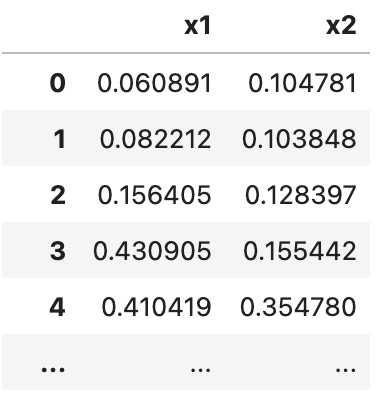

In [6]:

def MaterPointProcess_0_99(lambdaParent,lambdaDaughter,radiusCluster,plot=False):

    # Simulation window parameters
    xMin = 0;
    xMax = 1;
    yMin = 0;
    yMax = 1;

    # Extended simulation windows parameters
    rExt = radiusCluster;  # extension parameter -- use cluster radius
    xMinExt = xMin - rExt;
    xMaxExt = xMax + rExt;
    yMinExt = yMin - rExt;
    yMaxExt = yMax + rExt;

    # rectangle dimensions
    xDeltaExt = xMaxExt - xMinExt;
    yDeltaExt = yMaxExt - yMinExt;
    areaTotalExt = xDeltaExt * yDeltaExt;  # area of extended rectangle

    # Simulate Poisson point process for the parents
    numbPointsParent = np.random.poisson(areaTotalExt * lambdaParent);  # Poisson number of points
    
    # x and y coordinates of Poisson points for the parent
    xxParent = xMinExt + xDeltaExt * np.random.uniform(0, 1, numbPointsParent);
    yyParent = yMinExt + yDeltaExt * np.random.uniform(0, 1, numbPointsParent);

    # Simulate Poisson point process for the daughters (ie final poiint process)
    numbPointsDaughter = np.random.poisson(lambdaDaughter*np.pi*((radiusCluster)**2), numbPointsParent);
    #l'aire du cercle étant <1 cela nuit gravement au résultat à utiliser en fonction des valeurs des paramètres
    numbPoints = sum(numbPointsDaughter);

    # Generate the (relative) locations in polar coordinates by
    # simulating independent variables.
    theta = 2 * np.pi * np.random.uniform(0, 1, numbPoints);  # angular coordinates
    rho = radiusCluster * np.sqrt(np.random.uniform(0, 1, numbPoints));  # radial coordinates
    # Convert from polar to Cartesian coordinates
    xx0 = rho * np.cos(theta);
    yy0 = rho * np.sin(theta);

    # replicate parent points (ie centres of disks/clusters)
    xx = np.repeat(xxParent, numbPointsDaughter);
    yy = np.repeat(yyParent, numbPointsDaughter);

    # translate points (ie parents points are the centres of cluster disks)
    xx = xx + xx0;
    yy = yy + yy0;

    # thin points if outside the simulation window
    booleInside = ((xx >= xMin) & (xx <= xMax) & (yy >= yMin) & (yy <= yMax));
    # retain points inside simulation window
    xx = xx[booleInside];
    yy = yy[booleInside];

    # keeping the same digits precision as the simtub
    data = {'x1': xx, 'x2': yy}
    echantillon = pd.DataFrame(data)
    #echantillon = echantillon.astype(int)

    if plot:
            # Plotting
            fig, axs = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

            # First scatter plot
            axs[0].scatter(xx, yy, edgecolor='b', facecolor='none', alpha=0.5)
            axs[0].set_xlim([0, 1])
            axs[0].set_ylim([0, 1])
            axs[0].set_xlabel('x')
            axs[0].set_ylabel('y')
            axs[0].axis('equal')

            # Heatmap data
            heatmap_data = echantillon.pivot_table(index='x2', columns='x1', values='Simu')

            # Second heatmap plot
            cax = axs[1].imshow(heatmap_data, aspect='auto', origin='lower', cmap='viridis', extent=[0, 1, 0, 1])
            fig.colorbar(cax, ax=axs[1], label='Simu')
            axs[1].scatter(echantillon['x1'], echantillon['x2'], color='red', s=10)
            axs[1].set_xlabel('x1')
            axs[1].set_ylabel('x2')
            axs[1].set_title('Simu Values with Selected Points')

            plt.show()

    return(echantillon)

###  Créer_edge_graph


Prends en entrée un dataframe avec les coordonnées et la valeur prise par la réalisation pour chaque point

Créé un graph afin que le nombre maximum de voisins en tout point soit max_neighbors sont mis voisins deux points situés moins loin que threshold

Est mis en attribut d'arrête (=edge_attr) pour chaque point ladite distance entre les deux sommets de l'arrête

Return ledit graph 



In [7]:


def créer_edge_graph(echantillon, threshold, max_neighbors):
    edge_sources = []
    edge_destinations = []
    edge_features = []
    edge_attr=[]
    for i in range(len(echantillon)):
        distances = []
        for j in range(len(echantillon)):
            if i != j:
                dist = np.sqrt((echantillon.iloc[i]['x1'] - echantillon.iloc[j]['x1'])**2 + 
                               (echantillon.iloc[i]['x2'] - echantillon.iloc[j]['x2'])**2)
                if dist < threshold:
                    distances.append((dist, j))

        #distances = sorted(distances, key=lambda x: x[0])[:max_neighbors]
        if len(distances) > max_neighbors:
            distances = random.sample(distances, max_neighbors)

        for dist, j in distances:
            if (i, j) not in zip(edge_sources, edge_destinations):
                edge_sources.append(i)
                edge_destinations.append(j)
                edge_features.append(dist)
            if (j, i) not in zip(edge_sources, edge_destinations):
                edge_sources.append(j)
                edge_destinations.append(i)
                edge_features.append(dist)

    edge_index = torch.tensor([edge_sources, edge_destinations], dtype=torch.long)
    edge_features = torch.tensor(edge_features, dtype=torch.float).view(-1, 1)  # Convert to tensor and reshape

    node_features = torch.tensor(echantillon[['Simu']].values, dtype=torch.float)
    #node_features = torch.cat([node_features, torch.zeros((node_features.size(0), 1), dtype=torch.float)], dim=1)
    
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features)
    #data.D=torch.tensor(edge_features, dtype=torch.float)#.view(-1, 1)  # Convert to tensor and reshape
    return data


###  simu_echantillonage_graph

Crée un graph selon ce process :

1- Réalise le Matern Point Process pour extraire les coordonnées des points du graph
<br>
2- Ajoute une colonne 'Simu' au datframe contenant la réalisation de Matern en chaque point
<br>
3- Utilise créer_edge_graph fonction ci dessus pour faire le graph avec la vameur de Simu en node attribute et la distance entre deux points en edge attribute
<br>

return un graph avec une seule composante, et dont tous les points sont reliés

In [8]:

def simu_echantillonage_graph(range,param_model,lambdaParent,lambdaDaughter,radiusCluster,threshold,max_neighbors):

    echantillon_a=MaterPointProcess_0_99(lambdaParent,lambdaDaughter,radiusCluster,plot=False)#(100,50,0.10,False)
    db = gl.Db_fromPanda(echantillon_a)
    db.setLocators(["x1","x2"],gl.ELoc.X)

    model = gl.Model.createFromParam(type=gl.ECov.BESSEL_K, range = range, param = param_model)  # comment rajouter la NUGGET si il ne prends pas de typeS ?
    err = gl.simtub(None, db, model, None, nbsimu=1, seed=0, nbtuba = 1000) #seed=0 lance à chaque fois une simu différente
    #err = gl.Model.addCovFromParam(model,type=gl.ECov.NUGGET, sill = 1) ##Ajouter un nugget de variance 1

    df=pd.DataFrame({'Simu': db['z1']})
    echantillon_a = pd.concat([echantillon_a, df],axis=1)
    #print(echantillon_a)
    data=créer_edge_graph(echantillon_a,threshold,max_neighbors) #threshold=0.4 max_neighbors=10
    return(data)


### merge_components


Prends en entrée une liste de x graphs

Permets de fusionnés tous les graphs d'un même Deepset en un seul graph à x composantes non connexes
x est la taille du deepset.  x=deepset_size

Cette fonction est cruciale pour la création du jeu de données puisque elle s'assure que tous les graphs qui sont "fusionnés" au sein d'un graph à composantes non connexes ont des indices de noeuds et d'arrêtes qui sont tous distincts.

Le graph fusionné ce voit rajouté un attribut T attribut global qui contient le nombre de noeuds de chaque sous graph.

In [9]:

def merge_components(components,deepset_size):
    x_list = []
    edge_index_list = []
    edge_attr_list = []
    num_nodes_offset = 0
    i=0
    T=torch.empty(deepset_size)
    D=[]
    for component in components:
                
        component.edge_index,component.edge_attr = torch_geometric.utils.coalesce(component.edge_index,component.edge_attr,reduce='mean', is_sorted=True)
        x_list.append(component.x)
        edge_index_list.append(component.edge_index + num_nodes_offset)  # Ajuster les indices des arêtes
        edge_attr_list.append(component.edge_attr)
        num_nodes_offset += component.num_nodes
        T[i]=component.num_nodes
        #D+=(component.d)
        i+=1
    x = torch.cat(x_list, dim=0)
    edge_index = torch.cat(edge_index_list, dim=1)
    #edge_attr_list = torch.tensor(edge_attr_list, dtype=torch.float)
    #print(edge_attr_list)
    edge_attr = torch.cat(edge_attr_list, dim=0)
    graph = Data(x=x, edge_index=edge_index,edge_attr1=edge_attr)# edge_attr=edge_attr)
    graph.T=T
    return graph


###  simu_graph

Fonction qui crée un gros graph avec deepset_size composantes non connexes selon les paramètres d'une réalisation de Matern

Le graph se voit ajouter sa target data.y contenant les deux paramètres de la fonction de Matérn que l'on cherche à estimer


In [10]:

def simu_graph(deepset_size, range_val, param_model, lambdaParent, lambdaDaughter, radiusCluster, threshold, max_neighbors):
    data = [simu_echantillonage_graph(range_val, param_model, lambdaParent, lambdaDaughter, radiusCluster, threshold, max_neighbors) for i in range(int(deepset_size))]
    data=merge_components(data,deepset_size)
    data.y=torch.log(torch.tensor((range_val,param_model)))
    
    return data


###  composante_non_connexes


Fonction de vérification utile pour connaître le nombre de composantes non connexes d'un graph

In [11]:

def composante_non_connexes(data):
    adj_matrix = to_scipy_sparse_matrix(data.edge_index)
    num_components, labels = connected_components(adj_matrix, directed=False)
    print(f"Le graphe contient {num_components} composante(s) connexe(s).")
    return(num_components)

###  datamaker

Fonction qui créé le jeu de données avec n graphes composés chacun de deepset_size sous graphes

Les listes L et M sont utilisé dans la phase de test pour un modèles où n=4 ou moins

In [66]:


#L=[0.3,0.3,0.5,0.5]
#M=[0.7,0.7,0.5,0.5]
#L=[(0.3) for i in range(10)]+[(0.5) for i in range(10)]
#M=[(0.7) for i in range(10)]+[(0.5) for i in range(10)]


def datamaker(constant_product,n,deepset_size):

    
    datalist=[]
    range_list=np.random.uniform(0.05,0.5,n)
    variance_list=np.random.uniform(0.0,1.0,n)
    lambdaParent = np.random.uniform(50, 150,n)
    lambdaDaughter =[ (constant_product / lambdaParent[i]) for i in range(n) ]

    
    for i in range(n): 
        
        datalist.append(simu_graph(deepset_size,range_list[i],variance_list[i],lambdaParent[i],lambdaDaughter[i],0.10,0.4,10))         
        
        # pour les exemples de check avec des valeur de y qui sont fixées par les listes L et M
        #datalist.append(simu_graph(deepset_size,L[i],M[i],lambdaParent[i],lambdaDaughter[i],0.10,0.4,10))         

    print(f" Generated dataset size: {n * deepset_size}")
    
    return datalist


# Création des données

In [67]:

constant_product=7000
n=20
deepset_size=5
datalist=datamaker(constant_product,n,deepset_size)


 Generated dataset size: 100


In [68]:
datalist

[Data(x=[1168, 1], edge_index=[2, 10931], edge_attr1=[10931, 1], T=[5], y=[2]),
 Data(x=[1027, 1], edge_index=[2, 9470], edge_attr1=[9470, 1], T=[5], y=[2]),
 Data(x=[1015, 1], edge_index=[2, 9395], edge_attr1=[9395, 1], T=[5], y=[2]),
 Data(x=[1059, 1], edge_index=[2, 9885], edge_attr1=[9885, 1], T=[5], y=[2]),
 Data(x=[1057, 1], edge_index=[2, 9790], edge_attr1=[9790, 1], T=[5], y=[2]),
 Data(x=[1121, 1], edge_index=[2, 10486], edge_attr1=[10486, 1], T=[5], y=[2]),
 Data(x=[1149, 1], edge_index=[2, 10759], edge_attr1=[10759, 1], T=[5], y=[2]),
 Data(x=[1131, 1], edge_index=[2, 10561], edge_attr1=[10561, 1], T=[5], y=[2]),
 Data(x=[1173, 1], edge_index=[2, 11010], edge_attr1=[11010, 1], T=[5], y=[2]),
 Data(x=[1002, 1], edge_index=[2, 9281], edge_attr1=[9281, 1], T=[5], y=[2]),
 Data(x=[1072, 1], edge_index=[2, 10019], edge_attr1=[10019, 1], T=[5], y=[2]),
 Data(x=[1101, 1], edge_index=[2, 10244], edge_attr1=[10244, 1], T=[5], y=[2]),
 Data(x=[1115, 1], edge_index=[2, 10437], edge_att

### Création d'un dataset pytorch

In [69]:
class GraphSetDataset(Dataset):
    def __init__(self, datalist):
        self.datalist = datalist

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        return self.datalist[idx]


### Fonction collate pour gérer l'assemblage des graphes lors du batching

Dans la même idée que merge_components on s'assure que tous les graphs qui sont "fusionnés" au sein d'un graph à composantes non connexes ont des indices de noeuds et d'arrêtes qui sont tous distincts.

En effet lors du batching le loader de PyG fait des données (qu'il suppose être des graphes simples) d'un même batch un gros graph à composante non connexes.

In [70]:
def collate_fn(batch):

    x_list = []
    edge_index_list = []
    edge_attr_list = []
    num_nodes_offset = 0
    i=0
    labels = torch.empty(len(batch),2)
    
    for allset, label in batch:
        labels.append(label)
        x_list.append(allset.x)
        edge_index_list.append(allset.edge_index + num_nodes_offset)  # Ajuster les indices des arêtes
        edge_attr_list.append(allset.edge_attr)
        num_nodes_offset += allset.num_nodes


    x = torch.cat(x_list, dim=0)
    edge_index = torch.cat(edge_index_list, dim=1)
    edge_attr = torch.cat(edge_attr_list, dim=0)
    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    labels = torch.tensor( labels,dtype=torch.float32)

    return graph, labels

In [71]:
dataset = GraphSetDataset(datalist)

batch_size = 4

loader = DataLoader(dataset, batch_size, collate_fn=collate_fn, shuffle=True)

## Fin de la partie de création des données



# Création du model


### one_hot_encode_distance

Prends en entrée distance et threshold qui est la distance max de deux voisins

Fonction qui encode dans un tensor de taille 10  à quel dixeme de la distance max appartient distance

Fonction qui sera appliquée à tous les edges_attr

In [77]:

def one_hot_encode_distance(threshold, distance, epsilon=1e-5):
    if distance < epsilon or distance > threshold:
        raise ValueError(distance,threshold,"Distance should be within the range (0, threshold]")
    
    interval_length = threshold / 10
    interval_index = int(distance / interval_length)
    if interval_index == 10:
        interval_index = 9
    
    one_hot = torch.zeros(10, device=device)
    one_hot[interval_index] = 1
    
    return one_hot

In [78]:
one_hot_encode_distance(0.4,0.34)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [79]:
class expact(nn.Module):
    def forward(self, x):
        return torch.exp(x)
        


In [80]:
class EdgeFeatureMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, edge_output_dim):
        super(EdgeFeatureMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, edge_output_dim)
            #nn.Relu() #enlevé à checker
        ).to(device) 

    def forward(self, x):
        return self.mlp(x)
    

In [81]:
   
class MappingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MappingLayer, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)#,
            #expact()
            #enlever dans le cas où on s'intéresse desormais au log des  target classiques parametres kappa sigma à check
        )

    def forward(self, pooled_feature):
        device=pooled_feature.device
        out = self.mlp(pooled_feature.to(device))
        return out


In [82]:
class Couchewtilde(nn.Module):
    def __init__(self, in_channels, edge_hidden_dim, edge_output_dim, threshold):
        super(Couchewtilde, self).__init__()
        
        self.edge_mlp = EdgeFeatureMLP(in_channels, edge_hidden_dim, edge_output_dim)
        self.threshold = threshold
    
    def forward(self, data):

        #on veut mettre en edge attr wtilde en plus des simple distances
        # - le mettre dans le meme vecteur ou esssayer un tensor ?
        x, edge_index, edge_attr1 = data.x.to(device), data.edge_index.to(device), data.edge_attr1.to(device)
        #print('edge_attr1',edge_attr1.size())        
        mlp_output = self.edge_mlp(edge_attr1)
        #print('mlp_output',mlp_output.size())
        #essayer de faire disparaitre la boucle for cachée
        one_hot_features = torch.stack([one_hot_encode_distance(self.threshold, d.item()) for d in edge_attr1]).to(device)
        #print('one_hot_features',one_hot_features)
        #print('mlp_output',mlp_output)
        #print('mlp_output',mlp_output[45])
        w = torch.cat((one_hot_features, mlp_output), dim=1)        
        #print('w[45]',w[45])
        #print('normalement de taille 20 avec dabord le onehot puis mlpoutput',w.size())
        d = scatter(w, edge_index[0],reduce = 'sum') #sum over all neighbors
        #print('d[45] apres scatter_sum',d[45]) n'a aucun sens car size de d est le nb de noeudsx20
        #print('d size',d.size())
        #print('d après scatter',d)
        #print('d size après scatter',d.size())
        #d size après scatter torch.Size([nb de noeuds, 20])
        dtilde = d[edge_index[0]]  #### CHECK: on veut créer un vecteur comme edge_index[0] avec la valeur de d correspondante à chaque index)
        #print('dtilde[45]',dtilde[45])#.size())
        mask = dtilde != 0
        #print(mask[45])
        #edge_attr_j = edge_attr_combined[torch.nonzero((edge_index[0] == j) & (edge_index[1] == j_prime), as_tuple=True)].view(-1)
        replacement_tensor = torch.full((1, 20), 1e-5, device=device)
        wtilde = torch.where(mask, w / dtilde, replacement_tensor)    
        #wtilde = w / dtilde ### CHECK problème revoye parfois des 0 donc on ne peut pas diviser par 0
        #print('wtilde',wtilde.size())
        #print('wtilde_45',wtilde[45])
        data.edge_attrwtilde=wtilde
        #print('data',data)
        return data

In [83]:
class SpecialConv(MessagePassing):  ## created from CGConv
    # in edge attribute there is d_ij and wtilde_ij forall i,j (2D Tensor)
    
    def __init__(self, hidden_channels, moovingvaluegamma1):
        super().__init__(aggr='add')
        self.a = nn.Parameter(torch.rand(1, device=device)) # a in [0, 1]
        self.b = nn.Parameter(torch.rand(1, device=device) + 1) # b > 0
        self.gamma1 = nn.Parameter(torch.rand(hidden_channels, moovingvaluegamma1, device=device))
        self.gamma2 = nn.Parameter(torch.rand(hidden_channels, hidden_channels, device=device))
        self.biax = nn.Parameter(torch.rand(hidden_channels,1, device=device))
    
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor,
                edge_attr: torch.Tensor ) -> torch.Tensor:
        #print(x.size(),edge_attr.size())
        hbar = self.propagate(edge_index, x=x, edge_attr=edge_attr) ## vrai message passing
        #print('hbar.size()',hbar.size())
        hbar=hbar.transpose(1,0)
        #print('hbar.size()',hbar.size())
        
        #print('x.size()',x.size())
        x=x.transpose(1,0)
        #print('x.size()',x.size())
        #print('g1',self.gamma1.size())
        #print('g2',self.gamma2.size())

        #print('self.gamma1 @ x',(self.gamma1 @ x).size())
        #print('self.gamma2 @ hbar',(self.gamma2 @ hbar).size())

        #print(self.biax)
        #print(self.biax.size())
        out = self.gamma1 @ x + self.gamma2 @ hbar +  self.biax
        out=out.transpose(1,0)
        #out = torch.nn.functional.relu(out).squeeze() pb during backward->in place operation
        out = torch.nn.ReLU()(out).squeeze()

        return out

    def message(self, x_i, x_j, edge_attr: torch.Tensor) -> torch.Tensor:
        # on fait rho * wtilde (edge_attr[1])
        #
        rho = (torch.abs(self.a * x_i - (1 - self.a) * x_j)) ** self.b

        return rho * edge_attr


In [84]:

class DeepTEST(nn.Module):

    def __init__(self, in_channels, moovingvaluegamma1_1, moovingvaluegamma1_2, hidden_dim, edge_hidden_dim, edge_output_dim, threshold,mapping_hidden_dim, final_output_dim):# final_output_dim, mapping_hidden_dim, threshold):
        super(DeepTEST, self).__init__()
        
        self.Coucheinitialewtilde = Couchewtilde(in_channels, edge_hidden_dim, edge_output_dim, threshold)
        self.specialconv1 = SpecialConv(hidden_dim,moovingvaluegamma1_1)
        
        self.Coucheinterwtilde = Couchewtilde(in_channels, edge_hidden_dim, edge_output_dim, threshold)
        self.specialconv2 = SpecialConv(hidden_dim,moovingvaluegamma1_2)
        
        self.mapping = MappingLayer(hidden_dim, mapping_hidden_dim, final_output_dim)

    def forward(self, data):
        data = data.to(device)
        data_T=data.T.to(device)
        data_batch=data.T2.to(device)
        
        data = self.Coucheinitialewtilde(data)
        data.x = self.specialconv1(x=data.x, edge_index=data.edge_index, edge_attr= data.edge_attrwtilde)
        #print('postpremière couche',data)
        
        data=self.Coucheinterwtilde(data)
        data.x=self.specialconv2(x=data.x, edge_index=data.edge_index, edge_attr= data.edge_attrwtilde)
        #print('postdeuxieme couche',data)
        
        pooled_graphs = global_mean_pool(data.x, data_T) 
        #print('pooled_graphs',pooled_graphs)
        out=global_mean_pool(pooled_graphs, data_batch) 
        #print('out',out)
        output = self.mapping(out)
        output = output.view(-1)
        #print(output)
        return output

    
    


In [85]:
model = DeepTEST(in_channels=1,
                 moovingvaluegamma1_1=1,
                 moovingvaluegamma1_2=20 ,
                 hidden_dim=20,
                 edge_hidden_dim=128,
                 edge_output_dim=10,
                 threshold=0.40,
                 mapping_hidden_dim=128,
                 final_output_dim=2)
#in_channels=1, hidden_dim=20, edge_hidden_dim=128, edge_output_dim=10, final_output_dim=2, mapping_hidden_dim=128, threshold=0.40).to(device)

In [96]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


def train(model, optimizer, loader, n, batch_size): #leave=False,):
    model.train()
    MAE = torch.nn.L1Loss(reduction="mean")
    sum_loss = 0.0
    total = n // batch_size
    #t = tqdm(enumerate(loader), total=total, leave=leave)
    t=enumerate(loader)
    for i, batched_data in t:
        optimizer.zero_grad()

        T1 = []
        for j in range(len(batched_data.T)):
            T1.extend([j] * int(batched_data.T[j].item()))  
        batched_data.T = torch.tensor(T1, device=device)

        T2=[]
        for w in range(len(batched_data)):
            T2.extend([w] * deepset_size)
        batched_data.T2 = torch.tensor(T2, device=device)

        batched_data.y = batched_data.y.view(batch_size, 2) 
        batched_data = batched_data.to(device)

        output = model(batched_data)
        output=torch.reshape(output,(batch_size,2))
        #print('outputdetrain',output)

        if output.size(0) != batch_size or output.size(1) != 2:
            raise ValueError(f"Expected output shape ({batch_size}, 2) but got {output.size()}")

        y_batch = batched_data.y.to(device)
        #print('y_batch de train avant MAE',y_batch)  ## ybatch est sur le log des parametres classique
        batch_loss = MAE(output, y_batch)
        
        #print('training...')
        batch_loss.backward()
        optimizer.step()

        sum_loss += batch_loss.item()
        #t.set_description(f"loss = {batch_loss.item():.5f}")
        #t.refresh()

    return sum_loss / (i + 1)



In [97]:
torch.autograd.set_detect_anomaly(False)

# Epochs

  0%|                                                                                                                | 0/50 [00:00<?, ?it/s]

start of epoch: 1/50


  2%|██                                                                                                      | 1/50 [00:02<01:43,  2.11s/it]

Epoch: 00, Training Loss:   0.8557
start of epoch: 2/50


  4%|████▏                                                                                                   | 2/50 [00:04<01:37,  2.02s/it]

Epoch: 01, Training Loss:   1.2654
start of epoch: 3/50


  6%|██████▏                                                                                                 | 3/50 [00:06<01:33,  1.99s/it]

Epoch: 02, Training Loss:   1.0544
start of epoch: 4/50


  8%|████████▎                                                                                               | 4/50 [00:08<01:32,  2.01s/it]

Epoch: 03, Training Loss:   0.8480
start of epoch: 5/50


 10%|██████████▍                                                                                             | 5/50 [00:10<01:29,  1.99s/it]

Epoch: 04, Training Loss:   0.8395
start of epoch: 6/50


 12%|████████████▍                                                                                           | 6/50 [00:12<01:27,  2.00s/it]

Epoch: 05, Training Loss:   0.7795
start of epoch: 7/50


 14%|██████████████▌                                                                                         | 7/50 [00:14<01:25,  1.99s/it]

Epoch: 06, Training Loss:   0.7054
start of epoch: 8/50


 16%|████████████████▋                                                                                       | 8/50 [00:15<01:23,  1.98s/it]

Epoch: 07, Training Loss:   0.7360
start of epoch: 9/50


 18%|██████████████████▋                                                                                     | 9/50 [00:18<01:22,  2.01s/it]

Epoch: 08, Training Loss:   0.7320
start of epoch: 10/50


 20%|████████████████████▌                                                                                  | 10/50 [00:20<01:19,  2.00s/it]

Epoch: 09, Training Loss:   0.6932
start of epoch: 11/50


 22%|██████████████████████▋                                                                                | 11/50 [00:21<01:17,  1.98s/it]

Epoch: 10, Training Loss:   0.7328
start of epoch: 12/50


 24%|████████████████████████▋                                                                              | 12/50 [00:23<01:15,  1.99s/it]

Epoch: 11, Training Loss:   0.6780
start of epoch: 13/50


 26%|██████████████████████████▊                                                                            | 13/50 [00:25<01:13,  1.98s/it]

Epoch: 12, Training Loss:   0.6604
start of epoch: 14/50


 28%|████████████████████████████▊                                                                          | 14/50 [00:27<01:11,  1.99s/it]

Epoch: 13, Training Loss:   0.6673
start of epoch: 15/50


 30%|██████████████████████████████▉                                                                        | 15/50 [00:29<01:09,  1.98s/it]

Epoch: 14, Training Loss:   0.6673
start of epoch: 16/50


 32%|████████████████████████████████▉                                                                      | 16/50 [00:31<01:07,  1.97s/it]

Epoch: 15, Training Loss:   0.7154
start of epoch: 17/50


 34%|███████████████████████████████████                                                                    | 17/50 [00:33<01:05,  1.98s/it]

Epoch: 16, Training Loss:   0.6458
start of epoch: 18/50


 36%|█████████████████████████████████████                                                                  | 18/50 [00:35<01:03,  1.97s/it]

Epoch: 17, Training Loss:   0.6778
start of epoch: 19/50


 38%|███████████████████████████████████████▏                                                               | 19/50 [00:37<01:01,  1.99s/it]

Epoch: 18, Training Loss:   0.6637
start of epoch: 20/50


 40%|█████████████████████████████████████████▏                                                             | 20/50 [00:39<00:59,  1.98s/it]

Epoch: 19, Training Loss:   0.6503
start of epoch: 21/50


 42%|███████████████████████████████████████████▎                                                           | 21/50 [00:41<00:57,  1.97s/it]

Epoch: 20, Training Loss:   0.6615
start of epoch: 22/50


 44%|█████████████████████████████████████████████▎                                                         | 22/50 [00:43<00:55,  1.98s/it]

Epoch: 21, Training Loss:   0.6546
start of epoch: 23/50


 46%|███████████████████████████████████████████████▍                                                       | 23/50 [00:45<00:53,  1.97s/it]

Epoch: 22, Training Loss:   0.6607
start of epoch: 24/50


 48%|█████████████████████████████████████████████████▍                                                     | 24/50 [00:47<00:51,  1.99s/it]

Epoch: 23, Training Loss:   0.6804
start of epoch: 25/50


 50%|███████████████████████████████████████████████████▌                                                   | 25/50 [00:49<00:49,  1.97s/it]

Epoch: 24, Training Loss:   0.6634
start of epoch: 26/50


 52%|█████████████████████████████████████████████████████▌                                                 | 26/50 [00:51<00:47,  1.97s/it]

Epoch: 25, Training Loss:   0.6662
start of epoch: 27/50


 54%|███████████████████████████████████████████████████████▌                                               | 27/50 [00:53<00:45,  1.98s/it]

Epoch: 26, Training Loss:   0.6454
start of epoch: 28/50


 56%|█████████████████████████████████████████████████████████▋                                             | 28/50 [00:55<00:43,  1.97s/it]

Epoch: 27, Training Loss:   0.6965
start of epoch: 29/50


 58%|███████████████████████████████████████████████████████████▋                                           | 29/50 [00:57<00:41,  1.99s/it]

Epoch: 28, Training Loss:   0.6731
start of epoch: 30/50


 60%|█████████████████████████████████████████████████████████████▊                                         | 30/50 [00:59<00:39,  1.98s/it]

Epoch: 29, Training Loss:   0.6687
start of epoch: 31/50


 62%|███████████████████████████████████████████████████████████████▊                                       | 31/50 [01:01<00:37,  1.97s/it]

Epoch: 30, Training Loss:   0.6511
start of epoch: 32/50


 64%|█████████████████████████████████████████████████████████████████▉                                     | 32/50 [01:03<00:35,  1.98s/it]

Epoch: 31, Training Loss:   0.6779
start of epoch: 33/50


 66%|███████████████████████████████████████████████████████████████████▉                                   | 33/50 [01:05<00:33,  1.97s/it]

Epoch: 32, Training Loss:   0.6533
start of epoch: 34/50


 68%|██████████████████████████████████████████████████████████████████████                                 | 34/50 [01:07<00:31,  1.97s/it]

Epoch: 33, Training Loss:   0.6614
start of epoch: 35/50


 70%|████████████████████████████████████████████████████████████████████████                               | 35/50 [01:09<00:29,  1.98s/it]

Epoch: 34, Training Loss:   0.6415
start of epoch: 36/50


 72%|██████████████████████████████████████████████████████████████████████████▏                            | 36/50 [01:11<00:27,  1.97s/it]

Epoch: 35, Training Loss:   0.6552
start of epoch: 37/50


 74%|████████████████████████████████████████████████████████████████████████████▏                          | 37/50 [01:13<00:25,  1.99s/it]

Epoch: 36, Training Loss:   0.6379
start of epoch: 38/50


 76%|██████████████████████████████████████████████████████████████████████████████▎                        | 38/50 [01:15<00:23,  1.98s/it]

Epoch: 37, Training Loss:   0.6396
start of epoch: 39/50


 78%|████████████████████████████████████████████████████████████████████████████████▎                      | 39/50 [01:17<00:21,  1.97s/it]

Epoch: 38, Training Loss:   0.6624
start of epoch: 40/50


 80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 40/50 [01:19<00:19,  1.99s/it]

Epoch: 39, Training Loss:   0.6463
start of epoch: 41/50


 82%|████████████████████████████████████████████████████████████████████████████████████▍                  | 41/50 [01:21<00:17,  1.98s/it]

Epoch: 40, Training Loss:   0.6459
start of epoch: 42/50


 84%|██████████████████████████████████████████████████████████████████████████████████████▌                | 42/50 [01:23<00:16,  2.00s/it]

Epoch: 41, Training Loss:   0.6727
start of epoch: 43/50


 86%|████████████████████████████████████████████████████████████████████████████████████████▌              | 43/50 [01:25<00:13,  1.99s/it]

Epoch: 42, Training Loss:   0.6503
start of epoch: 44/50


 88%|██████████████████████████████████████████████████████████████████████████████████████████▋            | 44/50 [01:27<00:11,  1.98s/it]

Epoch: 43, Training Loss:   0.6537
start of epoch: 45/50


 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 45/50 [01:29<00:10,  2.00s/it]

Epoch: 44, Training Loss:   0.6541
start of epoch: 46/50


 92%|██████████████████████████████████████████████████████████████████████████████████████████████▊        | 46/50 [01:31<00:07,  1.99s/it]

Epoch: 45, Training Loss:   0.6514
start of epoch: 47/50


 94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 47/50 [01:33<00:05,  1.99s/it]

Epoch: 46, Training Loss:   0.6602
start of epoch: 48/50


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▉    | 48/50 [01:35<00:04,  2.00s/it]

Epoch: 47, Training Loss:   0.6986
start of epoch: 49/50


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 49/50 [01:37<00:01,  1.99s/it]

Epoch: 48, Training Loss:   0.6838
start of epoch: 50/50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:39<00:00,  1.99s/it]

Epoch: 49, Training Loss:   0.6530


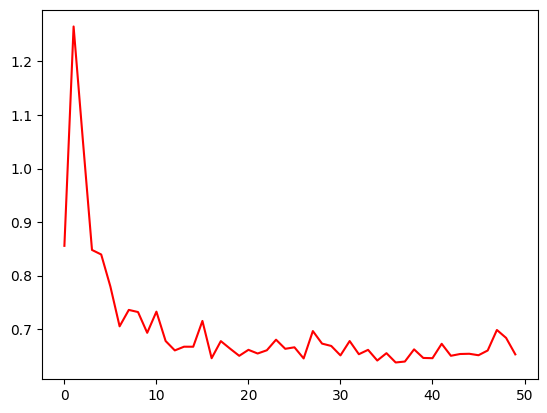

In [99]:
# Epoch loop
n_epochs = 50
Loss=[]
n = len(dataset)
#t = tqdm(enumerate(loader), total=total, leave=leave)



t = tqdm(range(0, n_epochs),total=n_epochs)

for epoch in t:

#for epoch in range(n_epochs):
    
    loss = train(
        model,
        optimizer,
        loader,
        n,
        batch_size,
        #leave=(epoch == n_epochs - 1),
    )
    #print(f'loss: {loss}')
    t.refresh()
    print("Epoch: {:02d}, Training Loss:   {:.4f}".format(epoch, loss))
    Loss.append(loss)




matplotlib.pyplot.plot(np.array(Loss), 'r')

FAire une explication de T1 et T2

In [68]:
t = enumerate(loader)
for i, batched_data in t:
    print(i,batched_data)
    print('batched_data.T',batched_data.T)

    T1 = []
    for j in range(len(batched_data.T)):
        T1.extend([j] * int(batched_data.T[j].item()))  
    batched_data.T = torch.tensor(T1, device=device)
    #print('batched_data.T1',batched_data.T)
    #print('len(batched_data.T1)',len(batched_data.T))



    T2=[]
    for w in range(len(batched_data)):
        T2.extend([w] * deepset_size)
    batched_data.T2 = torch.tensor(T2, device=device)
    #print('batched_data.T2',batched_data.T2)

    data=model(batched_data)

    #print('data.edge_attrwtilde_45',data.edge_attrwtilde[45])
    #print('data.edge_attr1_45',data.edge_attr1[45])

    print('data',data)



    

0 DataBatch(x=[608, 1], edge_index=[2, 5162], edge_attr1=[5162, 1], T=[6], y=[4], batch=[608], ptr=[3])
batched_data.T tensor([110., 110., 105.,  84., 120.,  79.])
data tensor([-12.8398,  -2.1347, -14.3863,  -2.2924], grad_fn=<ViewBackward0>)
1 DataBatch(x=[549, 1], edge_index=[2, 4469], edge_attr1=[4469, 1], T=[6], y=[4], batch=[549], ptr=[3])
batched_data.T tensor([ 80.,  84.,  95., 104.,  98.,  88.])
data tensor([ -9.8145,  -1.0584, -12.7682,  -1.5913], grad_fn=<ViewBackward0>)


### Mapping layer

### Création d'un dataset pytorch

In [ ]:

class GraphSetDataset(Dataset):
    def __init__(self, datalist):
        self.datalist = datalist

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        return self.datalist[idx]


### Fonction collate pour gérer l'assemblage des graphes lors du batching

Dans la même idée que merge_components on s'assure que tous les graphs qui sont "fusionnés" au sein d'un graph à composantes non connexes ont des indices de noeuds et d'arrêtes qui sont tous distincts.

En effet lors du batching le loader de PyG fait des données (qu'il suppose être des graphes simples) d'un même batch un gros graph à composante non connexes.



In [ ]:


def collate_fn(batch):

    x_list = []
    edge_index_list = []
    edge_attr_list = []
    num_nodes_offset = 0
    i=0
    labels = torch.empty(len(batch),2)
    
    for allset, label in batch:
        labels.append(label)
        x_list.append(allset.x)
        edge_index_list.append(allset.edge_index + num_nodes_offset)  # Ajuster les indices des arêtes
        edge_attr_list.append(allset.edge_attr)
        num_nodes_offset += allset.num_nodes


    x = torch.cat(x_list, dim=0)
    edge_index = torch.cat(edge_index_list, dim=1)
    edge_attr = torch.cat(edge_attr_list, dim=0)
    graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    labels = torch.tensor( labels,dtype=torch.float32)

    return graph, labels


# Définition training